# README

## Purpose
This notebook processes Hagashi-derived spot annotations, refines sub-label assignments, and visualizes embryo spatial maps and integrated UMAP embeddings. It (1) reconciles and reassigns spot categories across samples, (2) saves per-sample sublabel tables, (3) plots spatial layouts for all samples, and (4) plots UMAPs for integrated data.

## Key Steps
- Load per-sample Hagashi annotation CSVs and a YAML config.
- Reassign and harmonize labels into new sub-labels, saving `{sample}_hagashi_obs_sub.tsv`.
- Plot spatial coordinates of spots colored by sub-label for all samples and save `AllSample_Embryo_Spatial.pdf`.
- Load integrated AnnData (`intergrade/kept_samples_hagashi_intergrade.h5ad`), set plotting colors, and save UMAP figure `UMAP_samples_hagashi_intergrade.pdf`.

## Inputs
- Per-sample annotation files: `{label_dir}{sample}_hagashi_obs_new.csv`
- Integrated AnnData: `{label_dir}intergrade/kept_samples_hagashi_intergrade.h5ad`
- Configuration YAML: `{config_path}`

## Outputs
- `{save_dir}<sample>_hagashi_obs_sub.tsv` for each sample
- `{save_dir}AllSample_Embryo_Spatial.pdf`
- Saved UMAP PDF(s) via Scanpy (prefixed with `UMAP_...`)
- `{save_dir}README.md` (this file)

## Dependencies
- Python (3.6+)
- pandas, numpy, scanpy, seaborn, matplotlib, pyyaml

## Usage
1. Update paths and `sampleid_list` / color settings in the notebook if necessary.
2. Execute cells in order: configuration & imports, label processing, spatial plotting, UMAP plotting.
3. Inspect saved TSVs and PDF figures in the `save_dir`.

## Notes
- The notebook assumes `save_dir`, `label_dir`, and `config_path` are defined and writable.
- Adjust plotting and color dictionaries for custom visuals.

In [47]:
import yaml
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from matplotlib.gridspec import GridSpec
mpl.rcParams['pdf.fonttype'] = 42


subidx_list = [0, 1]
sublabel_list = ['Brain', 'Liver']
sampleid_list = [
    'E11.5L1', 'E11.5L2',
    'E12.5L5', 'E12.5L6', 'E12.5L9', 'E12.5S1',
    'E13.5C1', 'E13.5C4', 'E13.5C6', 
    'E14.5F5', 'E14.5F6', 'E14.5L7', 'E14.5L8', 'E14.5L10']

# 黄(#e8ac2d)：脑，红(#ef6666)：肝，蓝(#6fcce8 #129adb #9cdadb #53adcf #858ede #70a1ff #4f6dff)：其他
color_dict = {0: '#e8ac2d', 1: '#ef6666', 2: '#6fcce8', 3: '#129adb', 4: '#9cdadb', 5: '#53adcf', 6: '#858ede', 7: '#70a1ff', 8: '#4f6dff'}
color_name_dict = {'Brain': '#e8ac2d', 'Liver': '#ef6666', 'Other': '#6fcce8'}
stage_dict = {'E11.5': 'E11.5', 
    'E12.5': 'E12.5', 
    'E13.5': 'E13.5', 
    'E14.5': 'E14.5'}

label_dir = '/home/goubo/CRICK/CRICK/spaceA/hagash_v2/'
save_dir = '/home/xuyuetong/CRICK_Data_v3/Paper_Fig/'
config_path = '/home/goubo/CRICK/CRICK/spaceA/config_v2.yaml'
with open(config_path, 'r', encoding='utf-8') as file:
    config = yaml.safe_load(file)

In [ ]:
for s, sampleid in enumerate(sampleid_list):

    label_path = '{0}{1}_hagashi_obs_new.csv'.format(label_dir, sampleid)
    label_data = pd.read_csv(label_path, header=0, index_col=0)
    label_data = label_data[['spot_id', 'sample', 'x', 'y', 'hagashi_leiden', 'hagashi_leiden_anno', 'hagashi_leiden_anno_man']]
    label_data['hagashi_leiden_anno'] = label_data['hagashi_leiden_anno'].fillna('Unknown')
    label_data['hagashi_leiden_anno_man'] = label_data['hagashi_leiden_anno_man'].fillna('Unknown')

    for l, sub_label in enumerate(sublabel_list):
        sub_idx = subidx_list[l]
        original_idx = label_data[(label_data['hagashi_leiden'] == sub_idx) & (label_data['hagashi_leiden_anno'] != sub_label)].index
        if len(original_idx) > 0:
            replace_mask = (label_data['hagashi_leiden_anno'] == sub_label) & (label_data['hagashi_leiden'] != sub_idx)
            replace_value = label_data.loc[replace_mask, 'hagashi_leiden'].values[0]
            label_data.loc[replace_mask, 'hagashi_leiden'] = sub_idx
            label_data.loc[original_idx, 'hagashi_leiden'] = replace_value

    label_data['hagashi_leiden_sub'] = label_data['hagashi_leiden']
    sub_max = label_data['hagashi_leiden_sub'].max()
    for l, sub_label in enumerate(sublabel_list):
        sub_idx = subidx_list[l]
        label_data.loc[(label_data['hagashi_leiden_anno'] == sub_label) & (label_data['hagashi_leiden_anno_man'] == 'Unknown'), 'hagashi_leiden_sub'] = l + sub_max + 1

    label_save_path = '{0}{1}_hagashi_obs_sub.tsv'.format(save_dir, sampleid)
    label_data.to_csv(label_save_path, header=True, index=None, sep='\t')

In [4]:
# Plotting Spatial Embryo

row_num = 4
col_num = 4
fig = plt.figure(figsize=(4*row_num, 4*col_num), dpi=300)
gs = plt.GridSpec(row_num, col_num, hspace=0.3, wspace=0.4)

for s, sampleid in enumerate(sampleid_list):

    label_path = '{0}{1}_hagashi_obs_sub.tsv'.format(save_dir, sampleid)
    label_data = pd.read_csv(label_path, header=0, index_col=None, sep='\t')
    label_set = sorted(label_data['hagashi_leiden_sub'].unique())

    row_idx = s//col_num
    col_idx = s%col_num
    ax_spatial = fig.add_subplot(gs[row_idx, col_idx])
    
    for label_i in label_set:
        color_i = color_dict[label_i]
        ax_spatial.scatter(label_data[label_data['hagashi_leiden_sub'] == label_i]['x'], 
                           label_data[label_data['hagashi_leiden_sub'] == label_i]['y'], 
                           c=color_i, label=label_i, s=1)
    sample_info_dict = config['spatial_infor'][sampleid]
    if sample_info_dict['x_r']:
        ax_spatial.invert_xaxis()  # Reverse X axis
    if not sample_info_dict['y_r']:
        ax_spatial.invert_yaxis()  # Reverse Y axis 
    ax_spatial.set_aspect('equal')
    ax_spatial.set_title(sampleid)
    ax_spatial.set_xlabel('')
    ax_spatial.set_ylabel('')
    ax_spatial.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.2, fontsize=8, markerscale=5)

plot_path = '{0}AllSample_Embryo_Spatial.pdf'.format(save_dir)
plt.savefig(plot_path)
plt.close()

/tmp/ipykernel_3942005/3179380928.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs[color_key1] = adata.obs[color_key1].replace('None', 'Other')
/home/xuyuetong/miniconda3/envs/higashi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/xuyuetong/miniconda3/envs/higashi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hom

/home/xuyuetong/miniconda3/envs/higashi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


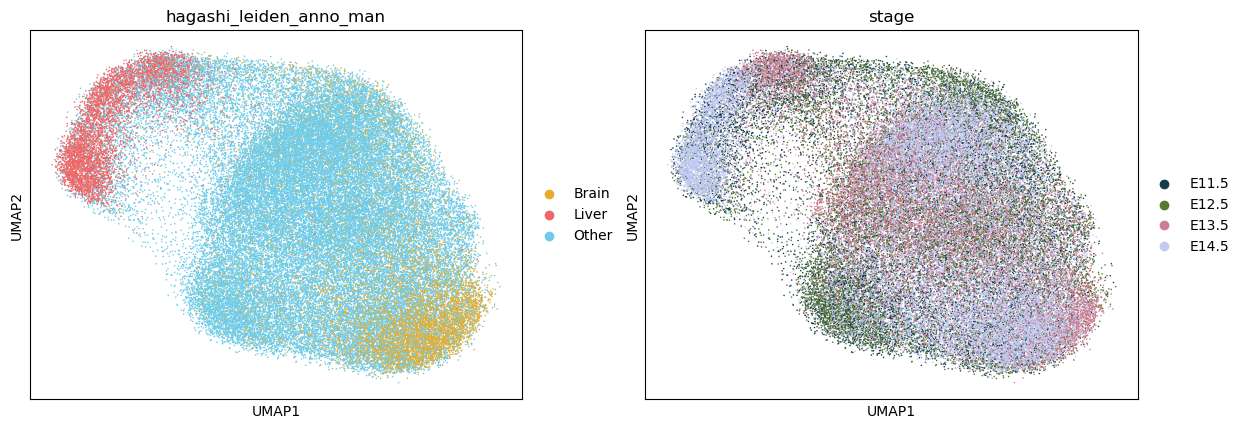

In [63]:
# Plotting UMAP

main_path = '{0}intergrade/kept_samples_hagashi_intergrade.h5ad'.format(label_dir)
adata = sc.read_h5ad(main_path)

color_key1 = 'hagashi_leiden_anno_man'
adata.obs[color_key1] = adata.obs[color_key1].replace('None', 'Other')
adata.uns[f'{color_key1}_colors'] = [color_name_dict[category] for category in adata.obs[color_key1].cat.categories]
color_key2 = 'stage'
adata.obs['stage'] = adata.obs['sample'].str[0:5]
adata.uns[f'{color_key2}_colors'] = [to_hex(color) for color in sns.color_palette("cubehelix", n_colors=4)]
sc.pl.umap(adata, color=[color_key1, color_key2], s=5, save='UMAP_samples_hagashi_intergrade.pdf')